In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

import re
import sys
import os

sys.path.append(os.path.abspath(os.path.join("..")))

import pandas as pd
from tqdm import tqdm
from pymystem3 import Mystem
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from joblib import Parallel, delayed

from utils import calc_metrics

import warnings
warnings.filterwarnings('ignore')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
X = pd.read_csv('../data/x.csv', index_col='date')
y = pd.read_csv('../data/y.csv', index_col='date').iloc[:, 0]

metrics = pd.read_csv('metrics.csv', index_col=0)

### N-граммы плюс Naive Bayes

Попробуем решить задачу с помощью алгоритма Naive Bayes, подберем оптимальные значения для параметра `ngram_range` и обучим лучшую модель.

In [3]:
mystem = Mystem()
STOP_WORDS = set(stopwords.words('russian'))

def preprocessor(text):
    text = text.lower()
    regex = re.compile('[^а-я А-ЯЁё]')
    text = regex.sub(' ', text)
    text = ' '.join(mystem.lemmatize(text))
    text = ' '.join([word for word in text.split() if word not in STOP_WORDS])
    return text

In [4]:
def _calc_metrics(start, stop):
    vectorizer = CountVectorizer(
        preprocessor=preprocessor,
        ngram_range=(start, stop)
    )
    bow_ngram = vectorizer.fit_transform(X.release)
    return calc_metrics(
        bow_ngram, y,
        MultinomialNB, 
        name='MultinomialNB',
        plot=False
    ), (start, stop)

auc = Parallel(n_jobs=-1)(delayed(
    _calc_metrics
)(start, stop) for start in range(1, 10) for stop in range(start, min(10, start + 4)))

(roc_auc, best_model), (start, stop) = max(auc, key=lambda x: x[0][0])

print(f"Лучшая модель - ngram_range({start}, {stop})")
print(f"ROC-AUC = {roc_auc}")

Лучшая модель - ngram_range(7, 7)
ROC-AUC = 0.7690450083542189


In [5]:
vectorizer = CountVectorizer(
    preprocessor=preprocessor,
    ngram_range=(start, stop)
)

vectorizer.fit(X.release)

bow_ngram = vectorizer.transform(X.release)

              precision    recall  f1-score   support

        -1.0       0.70      0.79      0.75        24
         0.0       0.50      0.36      0.42        28
         1.0       0.54      0.68      0.60        19

    accuracy                           0.59        71
   macro avg       0.58      0.61      0.59        71
weighted avg       0.58      0.59      0.58        71



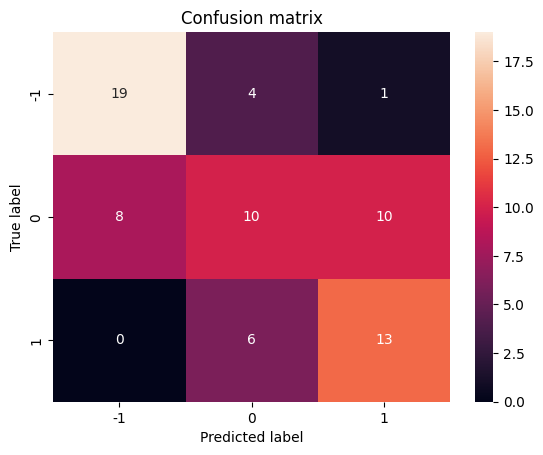

,accuracy,f1,precision,recall,roc_auc_ovr,roc_auc_ovo
min_baseline,0.660000,0.663508,0.665185,0.662014,0.741088,0.746510
bow l1 only release,0.619718,0.625363,0.638134,0.617586,0.769287,0.776198
bow elasticnet,0.605634,0.614252,0.627717,0.605681,0.782629,0.789369
bow release title,0.535211,0.540659,0.559180,0.530911,0.781719,0.787411
bow release all num,0.605634,0.608153,0.622475,0.600042,0.781633,0.786863
bow svc only release,0.661972,0.669910,0.690243,0.658939,0.777454,0.782790
tf_idf l1 only release,0.633803,0.636658,0.643844,0.633459,0.787036,0.793533
tf_idf only release best word,0.690141,0.687276,0.716378,0.677423,0.812873,0.818740
tf_idf title release,0.704225,0.704690,0.727814,0.694967,0.814459,0.819993
tf_idf numerical release,0.633803,0.636130,0.690598,0.619883,0.779646,0.783247


In [6]:
metric, model = calc_metrics(bow_ngram, y, MultinomialNB, name='MultinomialNB')
metrics = pd.concat((metrics, metric))
metrics

Получили качество хуже, чем минимальный безлайн.

In [7]:
metrics.to_csv('metrics.csv')